# Natural Gas Energy Indicators - Data Sets and Methodologies


## Importance of Energy Data:

Energy information is essential to drive forward-looking decision by governments, industries, and Canadians. It plays a key role in enhancing public confidence, economic competitiveness and the Government’s ability to support a transition to a low-carbon economy.

## Overview of Energy Information in Canada:
Energy information includes statistics, data, analysis and projections related to the production, transformation, distribution and consumption of energy; as well as the linkages between energy and the economy, society and environment.

Canada's energy information system is a collective contribution of several organizations, including:
- four federal departments or agencies:
  - Natural Resources Canada [(link)](https://www.nrcan.gc.ca/home);
  - Statistics Canada [(link)](https://www.statcan.gc.ca/eng/start);
  - Environment and Climate Change Canada [(link)](https://www.ec.gc.ca/?lang=En);
  - Canada Energy Regulator [(link)](https://www.cer-rec.gc.ca/index-eng.html);
- provincial and territorial government departments, regulators and utilities boards;
- energy market participants (ex. power producers, pipeline companies, system operators, etc.);
- industry associations and academic research bodies;
- Canada’ Open Government website [(link)](https://open.canada.ca/en);
- __Canadian Energy Information Portal (launched in June 2019) [(link)](https://www.statcan.gc.ca/eng/topics-start/energy).__

## Canadian Energy Information Portal:
Although Canadian energy information is abundant, it can be difficult to navigate, interpret and verify, particularly for non-experts. Moreover, data measurements, definitions and reporting standards vary amongst information providers. Often, data is not available in structured and machine-readable formats. Finally, data releases are often not timely, and lags are considered too long for a growing demand for real-time information.

Recognizing the complexity of Canada’s current energy information system, in June 2019, the Government of Canada launched the Canadian Energy Information Portal [(link)](https://www.statcan.gc.ca/eng/topics-start/energy). The Hub is a one stop shop for energy information that provides a single point of access for all federal-government statistics and provides links to existing body of energy information products.

## Goal of this notebook: 

- 1) Identify the main data set featured in Canada’s electricity markets __[Energy Indicators](https://www.cer-rec.gc.ca/nrg/tl/nrgcmmdt/nrgndctrlctrct-eng.html)__;
- 2) Load each data set used in the Energy Indicators into the Jupyter Notebook;
- 3) Chart each data set;
- 4) Provide links to other available data sets for more analysis.

__Data sets used in the Energy Indicators come from multiple free, publicly available sources. Data set files themselves are not provided to accompany the Notebook. Rather, data is loaded directly into the Notebook from the source provider. This ensures transparency, reproducibility and timeliness for the user.__ 

__Data sets used in this Notebook are often not in a flat, machine-readable format. Also, measurement units between various data sets are not standardized. Therefore to provide analytical value, each data set in the Notebook is transformed and standardized to ensure comparability.__

For units not available in this notebook, the Canada Energy Regulator offers a site with extensive energy conversion tables [(link)](https://apps.cer-rec.gc.ca/Conversion/conversion-tables.aspx?GoCTemplateCulture=en-CA). 

In [1]:
# download the following libraries
!pip install pyxlsb

# import the following libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
import zipfile
import io
import re
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from pyxlsb import open_workbook
from pandas.plotting import register_matplotlib_converters
pd.__version__ #To ensure your version of pandas is up to date follow the insructions as this link: https://stackoverflow.com/questions/53085501/how-to-upgrade-pandas-on-google-colab

# set global parameters
plt.style.use('ggplot')
register_matplotlib_converters()
sns.set_palette(sns.color_palette("tab20", 20))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Energy Indicators - Natural Gas:

### Natural gas prices

#### 1) Main dataset


Natural gas is a globally traded commodity and has a highly developed and integrated market. Gas can be traded between buyers and sellers for an immediate or near-term delivery (for a spot price), or for a forward dateded delivery (for a futures price). Spot and futures prices may vary depending on immediate and future expectations of market conditions. 

Daily spot and futures prices for natural gas are available from the Energy Information Agency and are updated daily (__[link](https://www.eia.gov/dnav/ng/hist/rngc1d.htm)__).  

Alberta natural gas prices are published by the Government of Alberta (__[link](https://economicdashboard.alberta.ca/NaturalGasPrice)__).  


#### 2) Load dataset

In [0]:
# download EIA Henry Hub spot price
url_hh = 'https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls'
sheet_hh = 'Data 1'
df_hh = pd.read_excel(url_hh, sheet_name=sheet_hh, index_col=None, header=2, parse_dates=['Date'])
df_hh['Date'] = df_hh['Date'].values.astype('datetime64[M]')
df_hh.set_index('Date', inplace=True)
df_hh['Henry Hub (US$/GJ)'] = df_hh['Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'] * 1.05505585

# download CN/US exchange rate from the federal reserve (US)
url_fed = 'https://www.federalreserve.gov/releases/h10/hist/dat00_ca.htm'
df_fed = pd.read_html(url_fed, index_col=['Date'], header=0, parse_dates=['Date'])[0]
df_fed['Rate'] = pd.to_numeric(df_fed['Rate'], errors='coerce')
df_fed = df_fed.resample('MS').mean()

# we are using the Fed Reserve exchange rate (above), but BofC exchange rate is another option
# download CN/US exchange rate from Bank Of Canada
# url_boc = 'https://www.bankofcanada.ca/valet/observations/FXUSDCAD/csv'
# df_boc = pd.read_csv(url_boc, index_col=['date'], header=6, parse_dates=['date'])
# df_boc = df_boc.resample('MS').mean()
# df_boc.index.rename('Date', inplace=True)

# access Alberta natural gas prices
url_ab = 'https://economicdashboard.alberta.ca/Download/DownloadFile?extension=csv&requestUrl=https%3A%2F%2Feconomicdashboard.alberta.ca%2Fapi%2FOilPrice'
df_ab = pd.read_csv(url_ab, index_col='When', header=0, parse_dates=['When']).rename(columns={'Alberta':'Alberta (CN$/GJ)'})
df_ab.index.rename('Date', inplace=True)
df_ab = df_ab[df_ab['Type'] == 'NatGas'][['Alberta (CN$/GJ)']]

# merge all prices and exchange rates
df_prices = df_ab.merge(df_hh[['Henry Hub (US$/GJ)']], 'left', on='Date').merge(df_fed, how='left', on='Date') # .merge(df_boc, 'left', on='Date')
df_prices['Henry Hub (CN$/GJ)'] = df_prices['Henry Hub (US$/GJ)'] * df_prices['Rate']
df_prices = df_prices[df_prices.index.year >= 2016][['Alberta (CN$/GJ)', 'Henry Hub (CN$/GJ)']]

#### 2) Chart data set

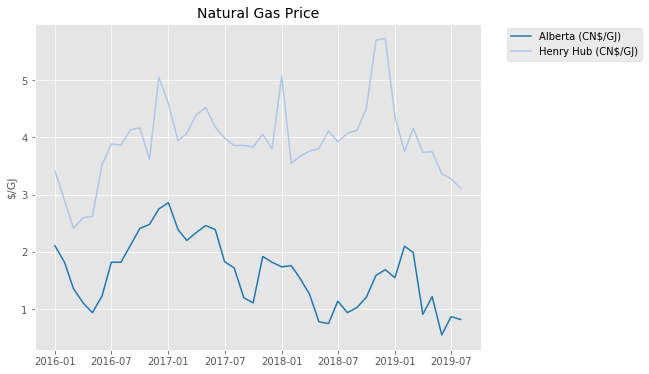

In [4]:
# create charts for natural gas prices
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))

ax1.plot(df_prices.index, df_prices)
ax1.set_ylabel('$/GJ', fontsize=11)
ax1.set_title('Natural Gas Price', fontsize=14)
ax1.legend(df_prices.columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

#### 4) Other datasets for Canadian natural gas prices

Natural gas prices for Canadian customer are also available from local natural gas distribution companies or provincial utility regulators.
This price data is often filed to utility regulators for review to ensure prudent gas supply.  
- Alberta natural gas prices are provided by the Alberta Utilities Commission [(link)](http://www.auc.ab.ca/pages/current-rates-gas.aspx);
- British Columbia natural gas prices are available from FortisBC [(link)](https://www.fortisbc.com/accounts-billing/billing-rates/natural-gas-rates/residential-rates);
- Saskatchewan natural gas prices are available from SaskEnergy [(link)](https://www.saskenergy.com/residential/resrates_hist.asp);
- Manitoba natural gas prices are provided by the Manitoba Public Utilities Board [(link)](http://www.pubmanitoba.ca/v1/regulated-utilities/natural-gas/rates/s_supply.html)
- Ontario natural gas prices are provided by the Ontario Energy Board [(link)](https://www.oeb.ca/rates-and-your-bill/natural-gas-rates);
- Québec natural gas prices are available from Energir [(link)](https://www.energir.com/en/business/price/natural-gas-price/);
- New brunswick natural gas prices are available from Enbridge Gas New Brunswick [(link)](https://naturalgasnb.com/en/for-home/accounts-billing/our-product-offering/#eug-rate-history);
- Nova Scotia natural gas prices are available from Heritage Gas ([(link)](http://www.heritagegas.com/natural-gas/historical-rates/).

#### 1) Main dataset
Data on the production of natural gas is collected by provinical governments and is used to assess the collection of royalties or support regulatory mandates. The NEB aggregates provincial government statistics and publishes the Marketable Natural Gas Production in Canada report [(link)](https://www.neb-one.gc.ca/nrg/sttstc/ntrlgs/stt/mrktblntrlgsprdctn-eng.html). Data is available since 2000 and is updated by the NEB monthly. Provincial government data may be delayed by up to 6 months.  

More specifically, the NEB aggregates the following province-level statistics:
- Government of British Columbia - Production and distribution of Natural Gas in BC report [(link)](http://www2.gov.bc.ca/gov/content/industry/natural-gas-oil/statistics);

    _Marketable Production = Residue Gas plant outlet - BC production only_
    
    
- Alberta Energy Regulator - ST3: Alberta Energy Resource Industries Monthly Statistics [(link)](https://aer.ca/providing-information/data-and-reports/statistical-reports/st3);

     _Marketable Production = Well Production + In Situ Well Production – flared – vented – shrinkage_ 
     
     
- Government of Saskatchewan  - Natural Gas Volume and Value Summary report [(link)](http://publications.gov.sk.ca/details.cfm?p=89506);

     _Marketable Production = Gas Available for Use or Sale_


- Canada - Nova Scotia Offshore Petroleum Board - Monthly Production Summary report [(link)](http://www.cnsopb.ns.ca/offshore-activity/weekly-activity-reports);

    _Marketable Production = raw gas production * 92.5_

#### 2) Load dataset to notebook

In [0]:
# access data from the Marketable Natural Gas Production in Canada report (published by the Canada Energy Regulator)

url_neb = 'https://www.cer-rec.gc.ca/nrg/sttstc/ntrlgs/stt/mrktblntrlgsprdctn-eng.html'  
sheet_prod = '2000+ - cubic feet per day'

r = requests.get(url_neb)
if r.status_code == 200:
  soup = bs(r.content)
  # find the most recent data set
  y = 0
  links = soup.find_all('a', attrs={'href': re.compile('^/nrg/sttstc/ntrlgs/stt/(.)*.xlsx?')})
  for link in links:
    new_y = int(link.get('href').split('.')[-2][-4:])
    if y < new_y:
      y = new_y
      url_prod = 'https://www.cer-rec.gc.ca' + link.get('href')
     
  df_prod = pd.read_excel(url_prod, sheet_name=sheet_prod, usecols='A:K', header=8, index_col=0, parse_dates=['Date']).dropna(1, 'all').dropna(0, 'all') / 1000
  df_prod.rename(columns={'NS':'Nova Scotia', 'NB':'New Brunswick', 'Sask':'Saskatchewan', 'BC':'British Columbia'}, inplace=True)
  df_prod = df_prod[df_prod.index.year >= 2016].dropna(0, 'any', subset=['Canada']).fillna(0)
else:
  print('Could not access CER page: ', url_neb)

#### 3) Chart data set

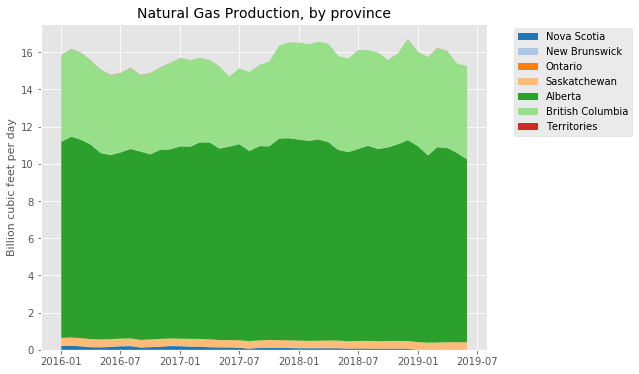

In [7]:
# chart Canadian natural gas production
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))

ax1.stackplot(df_prod.index, df_prod.drop('Canada', 1).T)
ax1.set_ylabel('Billion cubic feet per day', fontsize=11)
ax1.set_title('Natural Gas Production, by province', fontsize=14)
ax1.legend(df_prod.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

Alberta is the largest producer of natural gas in Canada, followed by British Columbia and Saskatchewan. Together, the three provinces produce 98 per cent of Canada's total production. Alberta's share of total production has decreased over the last ten years, as production in British Columbia increased.  

#### 4) Other datasets for Canadian natural gas production


Monthly natural gas production data is available from Statistics Canada's
_Supply and disposition of natural gas, Table 25-10-0055-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This report employs a different methodology to calculate production of marketable gas compared to the CER, and therefore the data between the two reports is not exact.

## Natural Gas Demand
Canadian demand for natural gas is seasonal, and increases in the winter, because of increased space heating demand. Alberta is Canada's largest natural gas consumer, because of its large industrial sector, including the oil sands.
#### 1) Main dataset
Statistics Canada publishes _Supply and disposition of natural gas (CANSIM Table 25-10-0055-01)_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This monthly report provides demand data for residential, commercial and industrial customer classes, and by province.

#### 2) Load data set

In [0]:
# Statistics Canada table 25100055, "Supply and disposition of natural gas, monthly"
# extract csv from a zip file
url_demand = 'https://www150.statcan.gc.ca/n1/tbl/csv/25100055-eng.zip'
file_name = '25100055.csv'
r = requests.get(url_demand, allow_redirects=True)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
df_demand_all = pd.read_csv(zip_file.open(file_name), index_col=None, header=0, parse_dates=['REF_DATE'])

# filter for end-use demand in cubic metres
keep = ['Residential consumption', 'Industrial consumption', 'Commercial consumption']
df_demand = df_demand_all[df_demand_all['Supply and disposition'].isin(keep) & (df_demand_all['UOM'] == 'Cubic metres')][['REF_DATE', 'GEO', 'Supply and disposition', 'VALUE']]

# clean up
df_demand['Value (Bcf/d)'] = df_demand['VALUE']/(df_demand['REF_DATE'].dt.daysinmonth) / 1000000 * 35.3147 # convert VALUE to bcf/d
df_demand.rename(columns={'REF_DATE':'Date', 'GEO':'Region', 'Supply and disposition':'Category'}, inplace=True)
df_demand_prov = df_demand.pivot_table(index='Date', columns='Region', aggfunc=np.sum)['Value (Bcf/d)']
df_demand_prov.columns = df_demand_prov.columns.str.replace('Northwest Territories', 'Territories')

#### 3) Chart data set

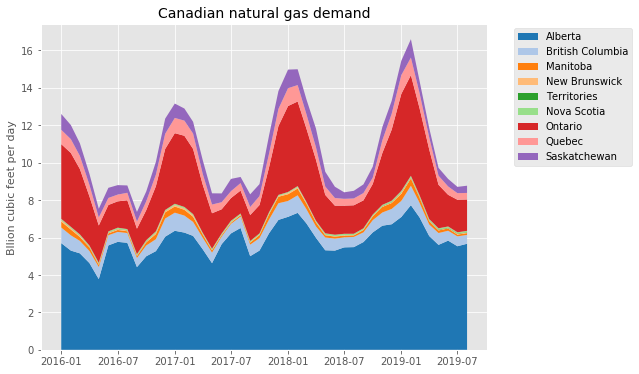

In [10]:
# chart natural gas end-use demand in Canada by province
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))

ax1.stackplot(df_demand_prov.index, df_demand_prov.drop('Canada', 1).T)
ax1.set_ylabel('Bllion cubic feet per day', fontsize=11)
ax1.set_title('Canadian natural gas demand', fontsize=14)
ax1.legend(df_demand_prov.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

Canadian natural gas demand is seasonal. Demand is highest in the winter when natural gas is used for space heating. The largest natural gas user in Canada is the industrial sector, which includes industries such as crude oil production, petrochemicals, manufacturing and power production. Alberta is the largest user of natural gas, followed by Ontario and Saskatchewan. 

#### 3) Other datasets for natural gas demand


Daily data on total Canadian demand is not available.

Canadian pipeline companies publish daily gas day summary reports on their websites, which aggregate pipeline users' daily nominations. Review of this data may provide an indication of daily natural gas demand in a specific region. Major pipelines that provide gas day summary reports include: 
- TransCanada Mainline pipeline [(link)](http://www.tccustomerexpress.com/2878.html);
- Nova Gas Transmission pipeline [(link)](http://www.tccustomerexpress.com/2878.html);
- Westcoast pipeline [(link)](https://noms.wei-pipeline.com/customer-activities/pipeline.php);
- Union Gas pipeline [(link)](https://www.uniongas.com/storage-and-transportation/informational-postings/gas-day-summary);
- TransGas pipeline [(link)](https://www.transgas.com/infopostings/apps/DailyOpsDetail.aspx);

Annual natural gas demand data by sector is available from Statistics Canada’s overall energy balances, _Supply and demand of primary and secondary energy in terajoules Table 25-10-0029-01_ [link](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901). This report includes data in energy units (terajoules), which allows across fuel comparisons and summation. Statistics Canada also publishes _Supply and demand of primary and secondary energy in natural units Table 25-10-0030-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001). This report contains the same data but in natural units, which vary by energy type (litres for liquid fuel, GWh for electricity, etc.) and therefore are not always additive or directly comparable across fuel types [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001);

## Natural gas exports
#### 1) Main dataset

Canada produces more natural gas than is required for domestic consumption. Remaining natural gas is exported to the United States via pipelines. The Canada Energy Regulator (CER) regulates the imports and exports of natural gas and collects import and export statistics from pipeline users. This information is available from the CER's Commodities Tracking System (__[link](https://apps.neb-one.gc.ca/CommodityStatistics/Statistics.aspx?language=english)__) and in flat format from Canada's Open Government website [(link)](https://open.canada.ca/data/en/dataset/b2f35cd0-4e54-4960-bdb1-7b040f5beaa0).

#### 2) Load data set

In [0]:
# access Natural Gas Exports and Imports data
url_trade = 'https://www.cer-rec.gc.ca/open/imports-exports/natural-gas-exports-and-imports-monthly.csv'
df_trade = pd.read_csv(url_trade, index_col='Period', header=0, parse_dates=['Period']) 
df_trade.index.rename('Date', inplace=True)

# assign province to each port
provinces = {'Aden':'Alberta','Armstrong':'Quebec','Blaine':'British Columbia','Brunswick':'New Brunswick','Canaport':'New Brunswick','Cardston':'Alberta','Champlain':'Quebec',
             'Chippawa':'Ontario','Cornwall':'Ontario','Corunna':'Ontario','Courtright':'Ontario','Coutts':'Alberta','East Hereford':'Quebec','Elmore':'Saskatchewan',
             'Emerson':'Manitoba','Fort Frances':'Ontario','Highgate Springs':'Quebec','Highwater':'Quebec','Huntingdon':'British Columbia','Iroquois':'Ontario',
             'Kingsgate':'British Columbia','Loomis':'Saskatchewan','Monchy':'Saskatchewan','Napierville':'Quebec','Niagara Falls':'Ontario','North Portal':'Saskatchewan',
             'Ojibway':'Ontario','Ojibway (Windsor)':'Ontario','Philipsburg':'Quebec','Port of Estevan':'Saskatchewan','Rainy River':'Ontario','Reagan Field':'Alberta',
             'Sarnia':'Ontario','Sarnia/Blue Water':'Ontario','Sault Ste Marie':'Ontario','Sierra':'Alberta','Sprague':'Manitoba','St Clair':'Ontario',
             'St Stephen':'New Brunswick','Willow Creek':'Saskatchewan','Windsor (Ojibway)':'Ontario', 'Total':'Canada'}
df_trade['Province'] = df_trade['Port'].map(provinces)

df_trade['Volume (Bcf/d)'] = df_trade['Volume (MCF)'] / 1000000 / (df_trade.index.days_in_month)
df_trade = df_trade[df_trade.index.year >= 2016][['Flow', 'Province', 'Volume (Bcf/d)']]

# get exports by province
df_exports = df_trade[df_trade['Flow'] == 'Exports'].pivot_table(index='Date', columns='Province', aggfunc=np.sum)['Volume (Bcf/d)'].fillna(0)

#### 3) Chart data set

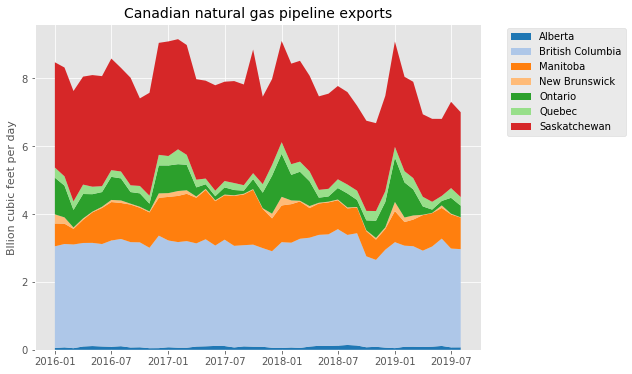

In [10]:
# create chart for exports
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))

ax1.stackplot(df_exports.index, df_exports.drop('Canada', 1).T)
ax1.set_ylabel('Bllion cubic feet per day', fontsize=11)
ax1.set_title('Canadian natural gas pipeline exports', fontsize=14)
ax1.legend(df_exports.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

Approximately half of Canada's natural gas production is exported to various markets in the United States via pipelines. The four main exporting provinces (where pipelines cross the Canada-US border) are British Columbia, Saskatchewan, Manitoba and Alberta. Provinces that produce little or no natural gas can still export significant amounts, because pipelines pass through these provinces to reach export markets.

#### 4) Other data sets for natural gas exports

Data on natural gas exports quantity and values by trading country can also be found in the Canadian International Merchandise and Trade (CIMT) database [(link)](https://www5.statcan.gc.ca/cimt-cicm/home-accueil?lang=eng). This report is based on customs-based trade data, which are derived from the administrative records of the Canadian Border Services Agency and the United States Customs Border Protection. The Harmonized System (HS) code for *natural gas* is 27112100. 

Statistics Canada publishes _Supply and disposition of natural gas (CANSIM Table 25-10-0055-01)_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This monthly report provides monthly exports data, by province.

Both of these reports employ a different methodology to calculate imports and exports compared to the NEB, and therefore the data between the three reports is not always identical.

## Natural gas imports
#### 1) Main data set

Natural gas import information is available from the CER's Commodities Tracking System (__[link](https://apps.neb-one.gc.ca/CommodityStatistics/Statistics.aspx?language=english)__) and in flat format from Canada's Open Government website [(link)](https://open.canada.ca/data/en/dataset/b2f35cd0-4e54-4960-bdb1-7b040f5beaa0).

#### 2) Load data set

In [0]:
# all the data for flows was download in the above section into df_flows, get the imports from the data
df_imports = df_trade[df_trade['Flow'] == 'Imports'].pivot_table(index='Date', columns='Province', aggfunc=np.sum)['Volume (Bcf/d)'].fillna(0)

#### 3) Chart data set

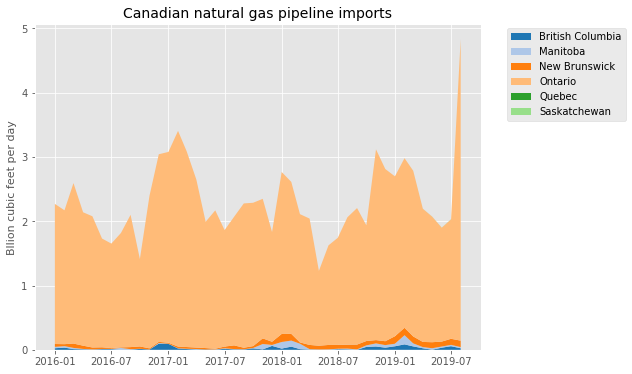

In [12]:
# create charts
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))

ax1.stackplot(df_imports.index, df_imports.drop('Canada', 1).T)
ax1.set_ylabel('Bllion cubic feet per day', fontsize=11)
ax1.set_title('Canadian natural gas pipeline imports', fontsize=14)
ax1.legend(df_imports.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

#### 4) Other data sets for natural gas imports

Data on natural gas imports quantity and values by trading country can also be found in the Canadian International Merchandise and Trade (CIMT) database [(link)](https://www5.statcan.gc.ca/cimt-cicm/home-accueil?lang=eng). This report is based on customs-based trade data, which are derived from the administrative records of the Canadian Border Services Agency and the United States Customs Border Protection. The Harmonized System (HS) code for *natural gas* is 27112100. 

Statistics Canada publishes _Supply and disposition of natural gas (CANSIM Table 25-10-0055-01)_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This monthly report provides monthly imports data, by province.

Both of these reports employ a different methodology to calculate imports and exports compared to the NEB, and therefore the data between the three reports is not always identical.

## Rig Count
#### 1) Main dataset
The rig count shows how many rigs are drilling for gas and indicates industry expectations of gas demand and prices. The rig count depends on  weather and is highly seasonal - activity is highest during winter, when the ground is frozen and rigs can move to most places. Activity is lowest in the spring, when the ground and roads thaw and rigs must be pulled from the field.

Baker Hughes is a large crude oil and natural gas extraction services company. Baker Hughes releases the North American rig count in a weekly report [(link)](http://phx.corporate-ir.net/phoenix.zhtml?c=79687&p=irol-reportsother). 

#### 2) Load data set

In [0]:
# access data (Baker Hughes Summary)
# this data is in xlsb (Excel Binary) format
url_bh = 'https://bakerhughesrigcount.gcs-web.com/na-rig-count'
sheet_rigs = 'Canada Oil & Gas Split'

r = requests.get(url_bh)
if r.status_code == 200:
  soup = bs(r.content)
  url_rigs = soup.find('a', text=re.compile('^North America Rotary Rig Count \(')).get('href')

  r = requests.get(url_rigs)
  if r.status_code == 200:
    data_rigs = []
    with open_workbook(io.BytesIO(r.content)) as wb:
      with wb.get_sheet(sheet_rigs) as ws:
        # regions are in row 6, labels in row 7, data in rows 8 and on
        for row in ws.rows():
          if row[0].r == 6:
            products = [item.v for item in row]
          elif row[0].r > 6:
            data_rigs.append([item.v for item in row])

    products = products[:-2] + [p + ' Percent of Total' for p in products[-2:]]
    df_rigs = pd.DataFrame(data_rigs, columns=products, 
                           index=None).dropna(1, 'all').dropna(0, 'all')
    df_rigs['DATE'] = pd.to_datetime(df_rigs['DATE'], unit='d', origin='1899-12-30')
    df_rigs.set_index('DATE', inplace=True)
  else:
    print('Could not access Rig Count Summary file: ', url_rigs)
  df_rigs = df_rigs[(df_rigs.index.year >= 2016)]
else:
  print('Could not access Baker Hughes page: ', url_bh)

Text(0.5, 1.0, 'Canada Natural Gas Rig Count')

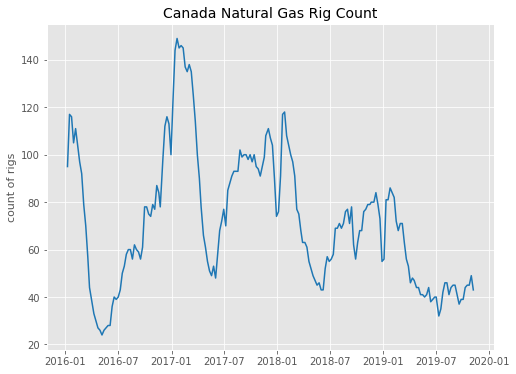

In [14]:
# create charts
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
ax1.plot(df_rigs.index, df_rigs['GAS']) 
ax1.set_ylabel('count of rigs', fontsize=11)
ax1.set_title('Canada Natural Gas Rig Count', fontsize=14) 

In [0]:
# access data (Baker Hughes Detail)
# this data is in xlsb (Excel Binary) format
url_bh = 'https://bakerhughesrigcount.gcs-web.com/na-rig-count'
sheet_rigs = 'Master Data'

r = requests.get(url_bh)
if r.status_code == 200:
  soup = bs(r.content)
  url_rigs = soup.find('a', text=re.compile('^North America Rotary Rig Count Pivot Table \(')).get('href')

  r = requests.get(url_rigs)
  if r.status_code == 200:
    data_rigs = []
    with open_workbook(io.BytesIO(r.content)) as wb:
      with wb.get_sheet(sheet_rigs) as ws:
        for row in ws.rows():
          data_rigs.append([item.v for item in row])
    df_rigs = pd.DataFrame(data_rigs[1:], columns=data_rigs[0], 
                           index=None).dropna(1, 'all').dropna(0, 'all')
    df_rigs['DATE'] = pd.to_datetime(df_rigs['PublishDate'], unit='d', origin='1899-12-30')
    df_rigs = df_rigs[(df_rigs['Country'] == 'CANADA') & (df_rigs['DrillFor'] == 'Gas') 
                      & (df_rigs['Year'] >= 2016)][['DATE', 'State/Province', 'RigCount']]
    df_rigs = df_rigs.groupby(['DATE', 'State/Province']).sum().reset_index()
    df_rigs = df_rigs.pivot_table(index='DATE', columns='State/Province', aggfunc=np.sum)['RigCount']
  else:
    print('Could not access Rig Count Detail file: ', url_rigs)
  
else:
  print('Could not access Baker Hughes page: ', url_bh)

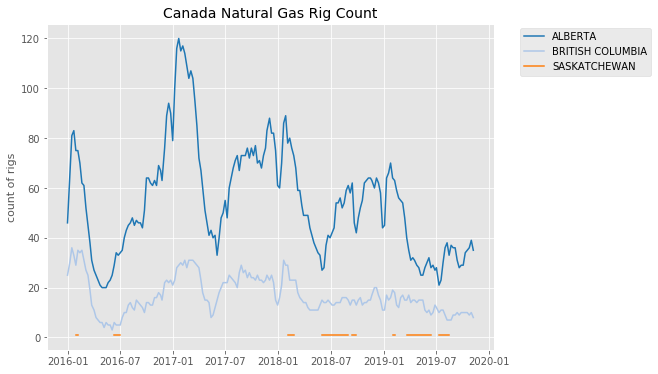

In [16]:
# create charts
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
ax1.plot(df_rigs.index, df_rigs) 
ax1.set_ylabel('count of rigs', fontsize=11)
ax1.set_title('Canada Natural Gas Rig Count', fontsize=14) 
ax1.legend(df_rigs.columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

The largest number of rigs in Canada are located in Alberta, where majority of Canadian natural gas production in Canada comes from. Rig activity has significant decreased since 2008, because companies have switched from drilling low productivity, vertical wells to drilling high productivity, horizontal wells. Over time, rig activity has tended to continue falling, because companies have increased their efficiencies, enabling the same rigs to drill more distance in the same amount of time.

#### 4) Other data sets for rig count

## Natural gas supply and demand projection

#### 1) Main dataset

The Canada Energy Regulator publishes the Energy Futures report [(link)](http://apps.neb-one.gc.ca/nrg/ntgrtd/ftr/2016/index-eng.html) - a projection of Canadian energy supply and demand to 2040. The report includes projections for supply and demand of natural gas. Projections are modeled based on historical data, and include a series of policy, technology and market assumptions outlined in the report. The report provides data appendices [(link)](https://apps.neb-one.gc.ca/ftrppndc/dflt.aspx?GoCTemplateCulture=en-CA) and interactive visualizations [(link)](https://apps2.cer-rec.gc.ca/dvs/?page=landingPage&language=en) to further explore Canada's energy future. The latest Energy Futures report was published in November 2018.

#### 2) Load data set

In [0]:
# access data 
url_ef = 'https://www.neb-one.gc.ca/nrg/ntgrtd/ftr/2018/fgrs-eng.xlsx'
sheet_gas = '3.19'
df_ef_gas = pd.read_excel(url_ef, sheet_name=sheet_gas, header=3, index_col=0).T.rename(columns = {'Net Exports':'Net Pipeline Exports'})

#### 3) Chart data set

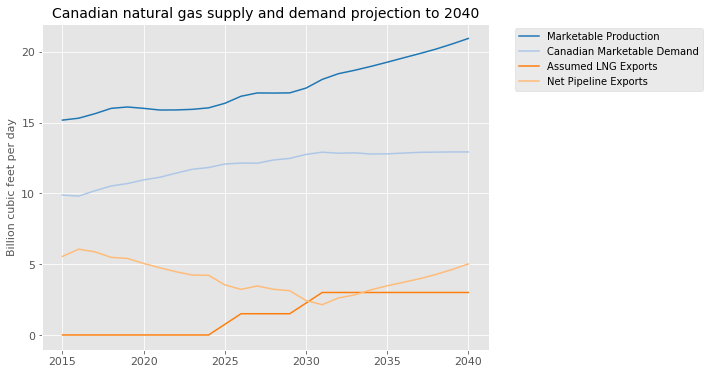

In [18]:
# chart
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.plot(df_ef_gas)
ax.set_title('Canadian natural gas supply and demand projection to 2040', fontsize = 14)
ax.legend(df_ef_gas.columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4, fontsize = 10) 
ax.set_ylabel('Billion cubic feet per day', fontsize = 11)
ax.tick_params(labelsize = 11);

Canada's natural gas supply is projected to come primarily from two provinces - Alberta and British Columbia. Alberta' production is forecast to average 11.7 Bcf/d in 2040. British Columbia's natural gas production is forecast to more than double from today, to average 9.2 Bcf/d in 2040. Saskatchewan's production is forecast to remain steady throughput the projection period, averaging 0.3 Bcf/d in 2040. 

#### 3) Other datasets for Canadian natural gas supply and demand forecast


The Alberta Energy Regulatorpulishes the ST98 Report, a projection of natural gas production in Alberta [(link)](https://www.aer.ca/providing-information/data-and-reports/statistical-reports/st98). 

At the international level, other government, non-government and corporate bodies publish global energy supply and demand statistics, which includes Canada. These include:
- US Energy Information Administration's International Energy Outlook 2018 [(link)](https://www.eia.gov/outlooks/ieo/);
- International Energy Agency World Energy Outlook [(link)](https://www.iea.org/weo/);
- BP Energy Outlook [(link)](https://www.bp.com/en/global/corporate/energy-economics/energy-outlook.html).

## Additional Resources
Please see the Canadian Energy Information Inventory (CCEI) [(link)](https://public.tableau.com/profile/energy.markets#!/vizhome/CanadianEnergyInformationInventoryCEII-V2_0/Datasets) - a government maintained searchable database for energy-related information and datasets in Canada. The CEII contains url links to over 200 datasets related to energy use and production in Canada and is searchable by issuer, commodity and category.

All the datasets used in this notebook are listed in the CEII. To provide feedback on the CEII, please email CEII-ICIE@neb-one.gc.ca.

## PyCon Presentation (17 Nov 2019)

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout, Box
import datetime

def f(z):
    return z

provs = ['Canada', 'Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Territories', 'Nova Scotia', 'Ontario', 'Quebec', 'Saskatchewan']
prov_dropdown = interactive(f, z=widgets.Dropdown(options=provs, description='Region', value='Canada'))

# display the drop down widget
display(prov_dropdown)

interactive(children=(Dropdown(description='Region', options=('Canada', 'Alberta', 'British Columbia', 'Manito…

In [20]:
prov = prov_dropdown.result

# merge all data for the province
df_all = df_prices
if prov in df_prod.columns:
  df_all = df_all.merge(df_prod[[prov]].rename(columns={prov:'Production'}), 'outer', 'Date')
else:
  df_all['Production'] = 0
if prov in df_demand_prov.columns:
  df_all = df_all.merge(df_demand_prov[[prov]].rename(columns={prov:'Demand'}), 'outer', 'Date')
else:
  df_all['Demand'] = 0
if prov in df_exports.columns:
  df_all = df_all.merge(df_exports[[prov]].rename(columns={prov:'Exports'}), 'outer', 'Date')
else:
  df_all['Exports'] = 0
if prov in df_imports.columns:
  df_all = df_all.merge(df_imports[[prov]].rename(columns={prov:'Imports'}), 'outer', 'Date')
else:
  df_all['Imports'] = 0

print(prov, ':')
df_all.sort_index().tail()
        

Canada :


,Alberta (CN$/GJ),Henry Hub (CN$/GJ),Production,Demand,Exports,Imports
Date,,,,,,
2019-04-01,0.91,3.740390,16.070217,11.853457,6.934661,2.194899
2019-05-01,1.22,3.749014,15.395124,9.725921,6.800894,2.072367
2019-06-01,0.55,3.364877,15.255961,9.132497,6.799587,1.900679
2019-07-01,0.87,3.276939,NaN,8.707693,7.301765,2.031271
2019-08-01,0.82,3.108866,NaN,8.769682,6.995672,4.831270


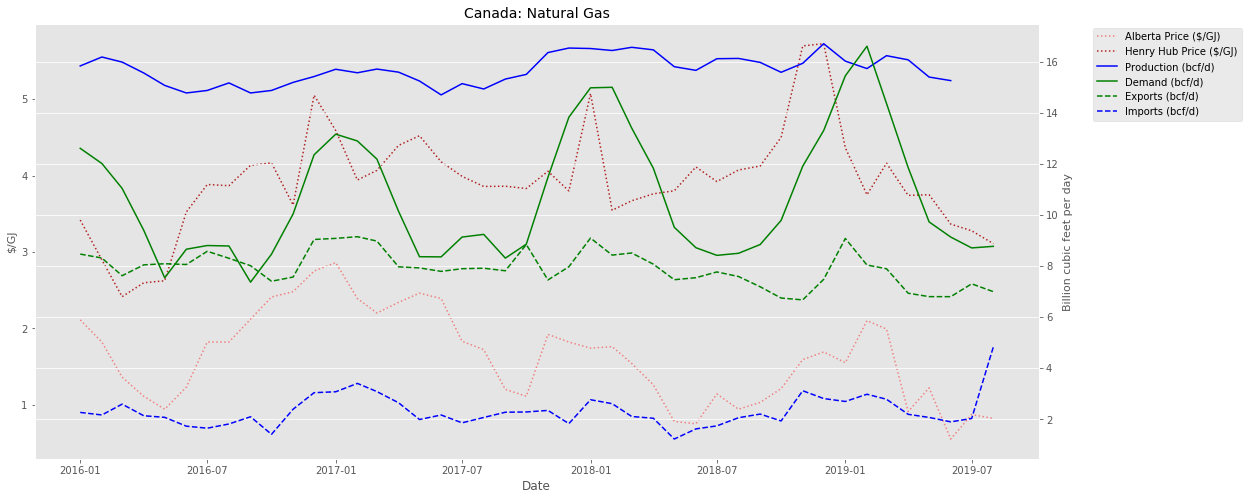

In [21]:
# chart - summary dashboard

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(18,8))
ax1.set_title(prov + ': Natural Gas', fontsize=14)

ab = ax1.plot(df_all.index, df_all['Alberta (CN$/GJ)'], label='Alberta Price ($/GJ)', color='lightcoral', linestyle=':')
hh = ax1.plot(df_all.index, df_all['Henry Hub (CN$/GJ)'], label='Henry Hub Price ($/GJ)', color='firebrick', linestyle=':')
ax2 = ax1.twinx()
prod = ax2.plot(df_all.index, df_all['Production'], label='Production (bcf/d)', color='blue')
dem = ax2.plot(df_all.index, df_all['Demand'], label='Demand (bcf/d)', color='green')
exp = ax2.plot(df_all.index, df_all['Exports'], label='Exports (bcf/d)', color='green', linestyle='--')
imp = ax2.plot(df_all.index, df_all['Imports'], label='Imports (bcf/d)', color='blue', linestyle='--')

# added these three lines
lns = ab + hh + prod + dem + exp + imp
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)

ax1.grid()
ax1.set_xlabel('Date')
ax1.set_ylabel('$/GJ', fontsize=11)
ax2.set_ylabel('Billion cubic feet per day', fontsize=11)
plt.show();

In [22]:
d_today = datetime.date.today()
d = datetime.datetime(d_today.year-1, d_today.month, 1)
df_year = df_all[df_all.index >= d]

print(prov, ' Snapshot Of Natural Gas Market For Past Year:')
df_year.sort_index()

Canada  Snapshot Of Natural Gas Market For Past Year:


,Alberta (CN$/GJ),Henry Hub (CN$/GJ),Production,Demand,Exports,Imports
Date,,,,,,
2018-11-01,1.59,5.698107,15.934049,11.907555,6.673916,3.117476
2018-12-01,1.69,5.727042,16.701200,13.302704,7.477283,2.811564
2019-01-01,1.55,4.364175,16.018473,15.443544,9.078009,2.697775
2019-02-01,2.10,3.748768,15.726926,16.601366,8.038653,2.980629
2019-03-01,1.99,4.161462,16.232055,14.362002,7.891812,2.784004
2019-04-01,0.91,3.740390,16.070217,11.853457,6.934661,2.194899
2019-05-01,1.22,3.749014,15.395124,9.725921,6.800894,2.072367
2019-06-01,0.55,3.364877,15.255961,9.132497,6.799587,1.900679
2019-07-01,0.87,3.276939,NaN,8.707693,7.301765,2.031271


In [23]:
df_snapshot = df_all.dropna(0, 'all').sort_index(ascending=False)
dates = df_snapshot.index.strftime('%b %Y')
d = dates[0]

dates_dropdown = interactive(f, z=widgets.Dropdown(options=dates, description='Month', value=d));

#display the tool
display(dates_dropdown)

interactive(children=(Dropdown(description='Month', options=('Aug 2019', 'Jul 2019', 'Jun 2019', 'May 2019', '…

In [24]:
d = dates_dropdown.result
d_s = datetime.datetime.strptime('01 ' + d, '%d %b %Y')
d_m = (d_s - datetime.timedelta(days=1)).replace(day=1)
d_y = datetime.datetime(d_s.year-1, d_s.month, 1)

df_snapshot = df_all.loc[[d_s, d_m, d_y], :]
df_snapshot.index = [d, 'Month Prior:', 'Year Prior:']

print(prov, ' Snapshot of Natural Gas Market For ', d, ':')
df_snapshot

Canada  Snapshot of Natural Gas Market For  Aug 2019 :


,Alberta (CN$/GJ),Henry Hub (CN$/GJ),Production,Demand,Exports,Imports
Aug 2019,0.82,3.108866,NaN,8.769682,6.995672,4.831270
Month Prior:,0.87,3.276939,NaN,8.707693,7.301765,2.031271
Year Prior:,0.94,4.073121,16.124044,8.497474,7.588376,2.061648
